In [1]:
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input

import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [3]:
def add_noise(image, noise_factor=0.3):
  noisey_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
  return np.clip(noisey_image,0,1)

In [4]:
X_train =  X_train / 255.0
X_test = X_test / 255

print(X_train.shape)

(60000, 28, 28)


In [5]:
X_train_noisy = np.array([add_noise(image) for image in X_train])
X_test_noisy = np.array([add_noise(image) for image in X_test])

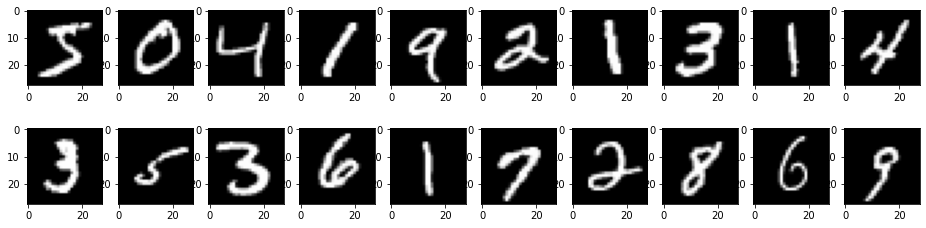

In [6]:
fig, axes = plt.subplots(2,10, figsize = (16, 4))

count = 0

for i in range(2):
    for j in range(10):
        axes[i,j].imshow(X_train[count], cmap = 'gray')
        count+=1

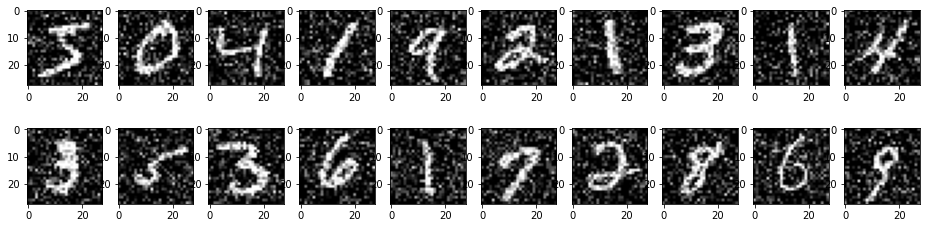

In [7]:
fig, axes = plt.subplots(2,10, figsize = (16, 4))

count = 0

for i in range(2):
    for j in range(10):
        axes[i,j].imshow(X_train_noisy[count], cmap = 'gray')
        count+=1

# **Model**

In [8]:
Input_layer = Input(shape=(28,28,1))

# Encoder
x = Conv2D(16,(3,3), activation="relu", padding="same")(Input_layer)
x = MaxPool2D(pool_size=(2,2),padding="same")(x)
x = Conv2D(8,(3,3), activation="relu", padding="same")(x)
x = MaxPool2D(pool_size=(2,2),padding="same")(x)
x = Conv2D(8,(3,3), activation="relu", padding="same")(x)
encoded = MaxPool2D(pool_size=(2,2),padding="same")(x)


# Decoder
x = Conv2D(8, (3,3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation="relu")(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1,(3,3), activation="relu", padding="same")(x)

autoencoder = Model(Input_layer, decoded)

In [9]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

In [10]:
encoder = Model(Input_layer, encoded)

decoder_layer = Input(shape=(4,4,8))

decoder = autoencoder.layers[7](decoder_layer)

for layer in autoencoder.layers[8:]:
  decoder = layer(decoder)

decoder = Model(decoder_layer, decoder)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 8)]         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 8)           584       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 16)        1168

In [11]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [14]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("denoising_model.h5", save_best_only=True, save_weights_only=False, verbose = 1)
history = autoencoder.fit(X_train_noisy, X_train, batch_size = 128, epochs = 10, callbacks = checkpoint, validation_split = 0.25, verbose = 2)


# autoencoder.fit(X_train_noisy, X_train, epochs=10, batch_size=128, validation_data=(X_test,X_test))

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.22198, saving model to denoising_model.h5
352/352 - 62s - loss: 0.3031 - val_loss: 0.2220 - 62s/epoch - 175ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.22198 to 0.20453, saving model to denoising_model.h5
352/352 - 62s - loss: 0.2182 - val_loss: 0.2045 - 62s/epoch - 175ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.20453 to 0.19684, saving model to denoising_model.h5
352/352 - 61s - loss: 0.2008 - val_loss: 0.1968 - 61s/epoch - 173ms/step
Epoch 4/10

Epoch 4: val_loss improved from 0.19684 to 0.19096, saving model to denoising_model.h5
352/352 - 62s - loss: 0.1944 - val_loss: 0.1910 - 62s/epoch - 176ms/step
Epoch 5/10

Epoch 5: val_loss improved from 0.19096 to 0.17983, saving model to denoising_model.h5
352/352 - 58s - loss: 0.1832 - val_loss: 0.1798 - 58s/epoch - 166ms/step
Epoch 6/10

Epoch 6: val_loss improved from 0.17983 to 0.17818, saving model to denoising_model.h5
352/352 - 60s - loss: 0.1952 - val_loss: 0.17

In [15]:
from keras.models import load_model
autoencoder = load_model('denoising_model.h5')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

In [16]:
def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 28,28)
    count = 0
    fig, axes = plt.subplots(row, column, figsize = (16,4))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(data[count], cmap = 'gray')
            count+=1

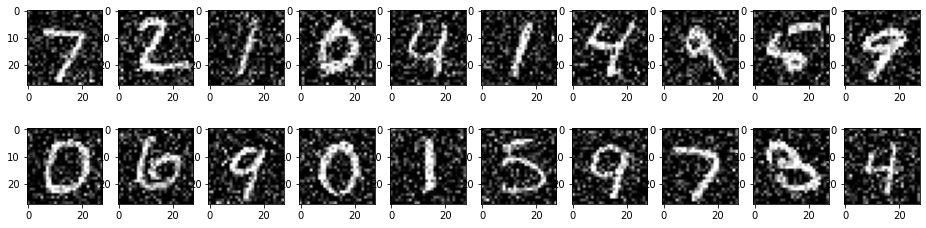

In [17]:
visualize_data(X_test_noisy[:20], 2,10)

1/1 [==============================] - 0s 207ms/step


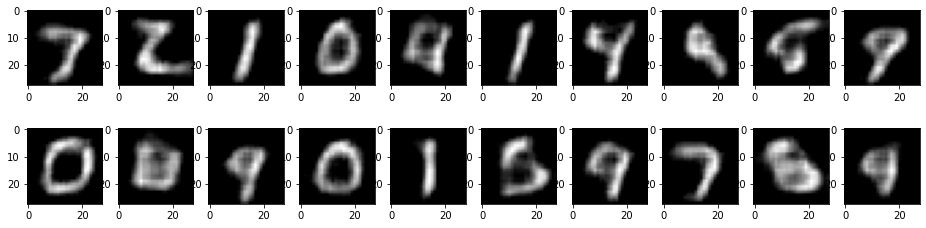

In [19]:
pred = autoencoder.predict(X_test_noisy[:20])
pred.shape
visualize_data(pred, 2, 10)